In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from scipy import signal
import time #testing de tiempos
from matplotlib import pyplot as plt
from PIL import Image
import torchaudio
from torchaudio import functional as F
import cProfile #testing de tiempos
from joblib import Parallel, delayed  #multithreading 

In [2]:
#input must be tensor with float (each bit)
def IndA_diff(input):
    weights = torch.tensor([[-7.8433e-04, 37.006, 37.006, 37.006, 37.005, 37.006, 37.006, 37.007]],dtype=torch.float64)
    bias = torch.tensor([-131.3873],dtype=torch.float64)
    linear_output = torch.matmul(input, weights.t()) + bias
    output = torch.sigmoid(linear_output)

    return output.item()

In [3]:
# Definir el modelo de regresión logística1
class LogisticRegressionB(nn.Module):
    def __init__(self):
        super(LogisticRegressionB, self).__init__()
        self.linear1 = nn.Linear(9, 20,dtype=torch.float64) 
        self.linear2 = nn.Linear(20, 10,dtype=torch.float64)
        self.linear3 = nn.Linear(10, 1,dtype=torch.float64)

    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = torch.sigmoid(self.linear3(x))
        return x

In [4]:
# Definir el modelo de regresión logística
class LogisticRegressionD(nn.Module):
    def __init__(self):
        super(LogisticRegressionD, self).__init__()
        self.linear1 = nn.Linear(9, 10,dtype=torch.float64) # 9 entradas y 20 salida
        self.linear2 = nn.Linear(10, 5,dtype=torch.float64)
        self.linear3 = nn.Linear(5, 1,dtype=torch.float64)

    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = torch.sigmoid(self.linear3(x))
        return x

In [5]:
IndB = LogisticRegressionB()
state_dictB = torch.load('indicatrizB.pth')
IndB.load_state_dict(state_dictB)
#input must be tensor with float (each bit)
def IndB_diff(bits):
    return IndB(bits).item()

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 15,dtype=torch.float64)  
        self.fc2 = nn.Linear(15, 1,dtype=torch.float64)  
        self.sigmoid = nn.Sigmoid()  # Función de activación sigmoide

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [7]:
IndE = Net()
state_dictE = torch.load('indicatrizE.pth', map_location=torch.device('cpu'))
IndE.load_state_dict(state_dictE)
#bits must be tensor and cnt integer
def IndE_diff(bits,cnt):
    cnt = torch.tensor([cnt],dtype=torch.float64)
    input = torch.cat((bits,cnt))
    return IndE(input).item()

In [8]:
IndC = Net()
state_dictC = torch.load('indicatrizC.pth', map_location=torch.device('cpu'))
IndC.load_state_dict(state_dictC)
#bits must be tensor and cnt integer
def IndC_diff(bits,cnt):
    cnt = torch.tensor([cnt],dtype=torch.float64)
    input = torch.cat((bits,cnt))
    return IndC(input).item()

In [9]:
IndD = LogisticRegressionD()
state_dictD = torch.load('indicatrizD.pth')
IndD.load_state_dict(state_dictD)
#input must be tensor with float (each bit)
def IndD_diff(bits):
    return IndD(bits).item()

In [10]:
def NegBit_diff(x):
    return 1 / (1 + np.exp(-(-15.43*x + 7.51)))

In [11]:
def Real2Bit_diff(x):
    return 1 / (1 + np.exp(-(-5.43 + 10.81*x)))

In [12]:
def XNOR_diff(x1, x2):
    fc1_weight = torch.tensor([[4.7662,  4.8464],[-0.1215,  1.3168],[ 2.6322,  2.3068],[-0.0951, -0.4683]],dtype=torch.float64)
    fc1_bias = torch.tensor([-1.5654,  0.3904, -3.6841, -0.0062],dtype=torch.float64)
    fc2_weight = torch.tensor([[-5.6381,  1.5594,  5.0998, -0.2311]],dtype=torch.float64)
    fc2_bias = torch.tensor([1.7433],dtype=torch.float64)

    x = torch.tensor([x1, x2],dtype=torch.float64)
    fc1_output = torch.sigmoid(torch.matmul(x, fc1_weight.transpose(0, 1)) + fc1_bias)
    fc2_output = torch.sigmoid(torch.matmul(fc1_output, fc2_weight.transpose(0, 1)) + fc2_bias)

    return fc2_output.item()

In [13]:
def XOR_diff(x1, x2):
    fc1_weight = torch.tensor([[-3.8973,  4.0330],[-4.1031,  3.8928],[-0.6775,  0.8108],[ 2.3834, -2.4550]],dtype=torch.float64)
    fc1_bias = torch.tensor([ 2.2917, -2.1209, -0.6751, -1.6954],dtype=torch.float64)
    fc2_weight = torch.tensor([[-4.5110,  5.7411,  1.0059,  2.4664]],dtype=torch.float64)
    fc2_bias = torch.tensor([0.8839],dtype=torch.float64)

    x = torch.tensor([x1, x2],dtype=torch.float64)
    fc1_output = torch.sigmoid(torch.matmul(x, fc1_weight.transpose(0, 1)) + fc1_bias)
    fc2_output = torch.sigmoid(torch.matmul(fc1_output, fc2_weight.transpose(0, 1)) + fc2_bias)

    return fc2_output.item()

In [14]:
def OR_diff(x1, x2):
    weight = torch.tensor([[13.5223, 13.5223]],dtype=torch.float64)
    bias = torch.tensor([-6.3024],dtype=torch.float64)
    x = torch.tensor([x1, x2],dtype=torch.float64)
    output = torch.sigmoid(torch.matmul(x, weight.transpose(0, 1)) + bias)

    return output.item()

In [15]:
#input must be float (each bit)
def q_m_diff(input):
    t_input = torch.tensor(input.copy(),dtype=torch.float64)
    output = torch.tensor([t_input[0], 0, 0, 0, 0, 0, 0, 0, 0],dtype=torch.float64)
    IndA = IndA_diff(t_input)
    for bit in range(1, 8):
        output[bit] = IndA * Real2Bit_diff(XNOR_diff(output[bit-1], t_input[bit])) + (1 - IndA) * Real2Bit_diff(XOR_diff(output[bit-1],t_input[bit]))
    output[8] = 1 - IndA
    return output


In [16]:
#input must be float (each bit) example: [0.0 1.0 1.0 1.0 0.0 0.0 0.0 1.0], 2.0
#output are tensors
def TMDS_diff(pixel_bits,cnt):
    bits_inversos = pixel_bits[::-1]
    q_m = q_m_diff(bits_inversos)
    q_m = Real2Bit_diff(q_m)
    output = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],dtype=torch.float64)
    IndB = IndB_diff(q_m[:9])
    IndE = IndE_diff(q_m[:8],cnt)
    IndC = IndC_diff(q_m[:8],cnt)
    Neg_q = NegBit_diff(q_m[:9])
    IndD = IndD_diff(q_m)
    output[:8] = q_m[:8] * OR_diff( IndE * IndB, (1-IndC) * (1-IndE)) + Neg_q[:8] * OR_diff((1 - IndB) * IndE, IndC * (1 - IndE))
    output[8] = q_m[8]
    output[9] = IndE * Neg_q[8] + (1 - IndE) * IndC
    new_cnt = IndE * ((cnt + torch.sum(q_m[:8] < 0.5).item() - torch.sum(q_m[:8] > 0.5).item()) * IndD + (cnt + torch.sum(q_m[:8] > 0.5).item() - torch.sum(q_m[:8] < 0.5).item()) * (1 - IndD)) + (1 - IndE) * ((cnt + 2 * q_m[8] + torch.sum(q_m[:8] < 0.5).item() - torch.sum(q_m[:8] > 0.5).item()) * IndC + (cnt - 2 * Neg_q[8] + torch.sum(q_m[:8] > 0.5).item() - torch.sum(q_m[:8] < 0.5).item()) * (1 - IndC))
    return output,new_cnt

In [17]:
def sigmoid(x):
    if x >= 0:
        return 1 / (1 + np.exp(-x))
    else:
        return np.exp(x) / (1 + np.exp(x))

def Pixel2Bit_diff(pixel):
    output = [0, 0, 0, 0, 0, 0, 0, 0]
    for i in range(1,9):
        output[i-1] = sigmoid(10*(pixel-2**(8-i)+0.5))  # 0.5 para ajustar la sigmoidal
        if pixel >= 2**(8-i):
            pixel = pixel - 2**(8-i)
    return output

In [49]:
#funcion que toma como entrada el armonico a sintonizar y las dimensiones de la imagen a espiar y devuelve un array con taps de g(t)
def g_taps(dim_vertical, dim_horizontal, armonico):

    #defino variables iniciales
    f_b = 10 * (dim_vertical * dim_horizontal * 60)
    f_sdr = 50e6
    harm = armonico * f_b
    
    #para el correcto funcionamiento: dependiendo del armonico, elijo cuantas muestras por pulso
    if (armonico < 5 ):
        muestras_por_pulso  = 10
    else:
        muestras_por_pulso  = 20

    samp_rate = muestras_por_pulso * f_b
    H_samples = dim_horizontal * muestras_por_pulso

    #creo el pulso
    t_continuous = np.linspace(start = 0, stop = H_samples/samp_rate, num = H_samples, endpoint= False)
    pulso = np.zeros(H_samples)
    pulso[:muestras_por_pulso] = 0.7/255

    #traslado el espectro del pulso el armonico correspondiente
    frec_armonico = np.exp(-2j*np.pi*harm*t_continuous)
    pulso_complejo = pulso*frec_armonico

    #creo el lpf del sdr
    b, a = signal.butter(6, f_sdr/2, fs=samp_rate, btype='lowpass', analog=False)

    #filtro con lpf el pulso multiplicado por armonico. El resultado es g
    g_t = signal.lfilter(b, a, pulso_complejo)

    # si arminico crece, necesito mas taps
    if (armonico < 5):
        g_t = g_t[:1500]
    else:
        g_t = g_t[:3000]

    g_t_max = np.max(np.abs(g_t))
 
    g_t = g_t / g_t_max

    return torch.tensor(g_t,dtype = torch.complex64).reshape(1,1,len(g_t))

In [19]:
def TMDS_2_row(multiplicador,cant_filas,img,columnas, g_t, padding):
    #bits_cod_filas =  torch.zeros(10*columnas*cant_filas,dtype = torch.complex64)
    #img_salida = torch.zeros((cant_filas, columnas + 300),dtype = torch.complex64)
    img_salida = torch.zeros((cant_filas, columnas),dtype = torch.complex64)
    bits_cod_cant_filas = torch.zeros((1,1,10*columnas*cant_filas),dtype = torch.complex64)
    for i in range(multiplicador*cant_filas, cant_filas*(multiplicador+1)):
        cnt = 0
        bits_cod_fila =  torch.zeros((1, 1, 10*columnas),dtype = torch.complex64)
        #bits_cod_fila = torch.cat((torch.zeros((1,1,750), dtype = torch.complex64), bits_cod_fila), dim = 2)
        for j in range(columnas):
            pixel = img[i,j]
            pixel_bits = Pixel2Bit_diff(pixel)
            pixel_cod,cnt = TMDS_diff(pixel_bits, cnt)  
            #bits_cod_fila[0,0,750 + j*10:750 + (j+1)*10] = pixel_cod
            bits_cod_fila[0,0,j*10:(j+1)*10] = pixel_cod
        #bits_cod_fila = torch.cat((bits_cod_fila, torch.zeros((1,1,750), dtype = torch.complex64)),  dim = 2)
        #bits_cod_cant_filas[0,0,(1500+10*columnas)*(i-multiplicador*cant_filas):(1500+10*columnas)*((i-multiplicador*cant_filas)+1)] = bits_cod_fila
        bits_cod_cant_filas[0,0,(10*columnas)*(i-multiplicador*cant_filas):(10*columnas)*((i-multiplicador*cant_filas)+1)] = bits_cod_fila
    img_salida = nn.functional.conv1d(bits_cod_cant_filas, g_t, stride = 10, padding=padding, bias = None)[0,0,:].reshape((cant_filas,columnas))
    return img_salida

In [20]:
def encontrar_mayor_divisor(a, b): 
    while b != 0:
        a, b = b, a % b
    return a

def Calc_filas_por_thread(filas, threads):  #calculo la max cantidad de filas para que todos calculen la misma cantidad y no sobrem filas, para pasarle a cada hilo de forma de optimizar el uso de los hilos. Pasarle de a pocas filas es ineficiente
    divisor = encontrar_mayor_divisor(filas,threads)
    return filas // divisor

In [21]:
def forward(img, armonico,num_threads):
    filas, columnas = img.shape
    g_t = g_taps(filas, columnas, armonico)
    #g_t = torch.tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0],dtype = torch.complex64).reshape(1,1,10)
    size_g_t = g_t.numel()    
    padding = (size_g_t - 10)//2
    filas_por_thread = Calc_filas_por_thread(filas,num_threads)
    result = Parallel(n_jobs=num_threads)(delayed(TMDS_2_row)(multiplicador,filas_por_thread,img,columnas, g_t, padding) for multiplicador in range(num_threads)) # da mejores resultados por poquito el multiprocessing (Pool)
    if num_threads == 1:
        imagen_salida = result[0]
    else:
        imagen_salida = result[0]
        for i in range(1, len(result)):
            imagen_salida = torch.cat((imagen_salida, result[i]), dim = 0)

    return imagen_salida

In [47]:
image_path = '../images/VAMO!!.png'
img = np.asarray(Image.open(image_path))[:,:,0]
#img = np.zeros((256,256))
armonico = 3
num_threads = 10  # elegir numeros de hilos del cpu (dejar alguno libre para que no explote la PC)
#cProfile.runctx('forward(imag,armonico)', globals(), locals()) 
imagen = forward(img, armonico,num_threads)


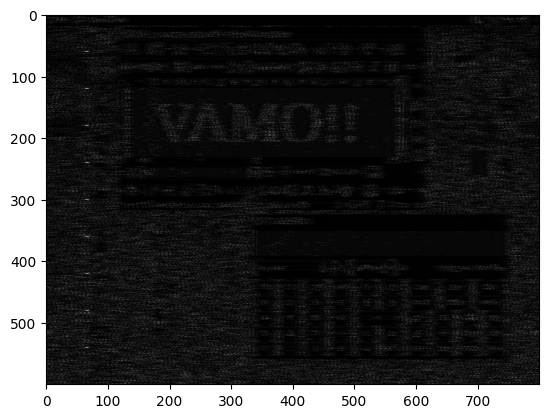

In [48]:
img_sim = np.abs(imagen.numpy())
img_sim = 255*img_sim/img_sim.max()
plt.figure()
plt.imshow(img_sim,cmap='gray')
#plt.imshow(255*((img_sim - img_sim.min())/(img_sim.max()-img_sim.min())),cmap='gray')
plt.show()


In [24]:
I_save = 255*((img_sim - img_sim.min())/(img_sim.max()-img_sim.min()))
im = Image.fromarray(I_save.astype('uint8'))
im.save('../images/vamo.png')
